In [1]:
from time import time
from os import path, mkdir

import matplotlib.pyplot as plt
#plt.style.use(['science','ieee'])

import numpy as np
import pickle

import soundfile as sf
from scipy import fftpack
import scipy.io as sio
import scipy.signal as sig
import scipy

from utils import plot_atoms8, load_obj, getwin, save_obj
from utils import regress_atom

In [2]:
sn = 'nonstationary440_sim1_5k'

mat_adr = '../datasets/' + sn + '.mat'

# load data to sort atoms
print('load mat data at:',mat_adr)
mat_dic = sio.loadmat(mat_adr)
ys = mat_dic['ys']
fs = mat_dic['fs'][0]
print('signals',ys.shape)
print('fs',fs)
L = 5000
K = 2
ws = 40e-3
window = 4
segsize = int(ws*fs)
for l in range(L):
    signal = ys[l,:]    
    win = getwin(window)
    iF,iT,X = sig.stft(signal,fs,window=win,nperseg=segsize,return_onesided=False,boundary='even')
    Y = np.real(scipy.ifft(X,axis=0))
    if l==0:
        M = Y.shape[0]
        N = Y.shape[1]
        F = M
        Ys = np.zeros((L,F,N))
    Ys[l,:,:] = Y

    

load mat data at: ../datasets/nonstationary440_sim1_5k.mat
signals (5000, 15000)
fs [5000]


/home/zsx/anaconda3/envs/nmf/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.ifft is deprecated and will be removed in SciPy 2.0.0, use scipy.fft.ifft instead


In [3]:

Sout = [1,10,100,1000,5000]
tlname = ['tlnmf2_best2_itl100_Ttl1_Tnmf10_epsnmf5e-07_epsc5e-07_ws40ms_me_nbrun10/tlnmf2_sci_batch_K2_S1_win4',
          'tlnmf2_best2_itl100_Ttl1_Tnmf10_epsnmf5e-07_epsc5e-07_ws40ms_me_nbrun10/tlnmf2_sci_batch_K2_S10_win4',
          'tlnmf2_best2_itl100_Ttl1_Tnmf10_epsnmf5e-07_epsc5e-07_ws40ms_me_nbrun10/tlnmf2_sci_batch_K2_S100_win4',
          'tlnmf2_best2_itl100_Ttl1_Tnmf10_epsnmf5e-07_epsc5e-07_ws40ms_me_nbrun10/tlnmf2_sci_batch_K2_S1000_win4',
          'tlnmf2_best2_itl100_Ttl1_Tnmf10_epsnmf5e-07_epsc5e-07_ws40ms_me_nbrun10/tlnmf2_sci_batch_K2_S5000_win4',
         ]
jdname = ['tlnmfJD2_sci_batch_K2_S1_win4_ws40ms_epsnmf5e-07_epsc5e-07_best',
          'tlnmfJD2_sci_batch_K2_S10_win4_ws40ms_epsnmf5e-07_epsc5e-07_best',
          'tlnmfJD2_sci_batch_K2_S100_win4_ws40ms_epsnmf5e-07_epsc5e-07_best',
          'tlnmfJD2_sci_batch_K2_S1000_win4_ws40ms_epsnmf5e-07_epsc5e-07_best',
          'tlnmfJD2_sci_batch_K2_S5000_win4_ws40ms_epsnmf5e-07_epsc5e-07_best',
         ]  

def load_PhiWH(plotid,mode):    
    # get sorted Phi,W and original H
    #mode = 'jdnmf'
    #mode = 'tlnmf'  
    #plotid = 0 # S=1
    #plotid = 2 # S=100
    sid = plotid
    S = Sout[sid]
    if sid == 0:
        assert(S==1)
    elif sid == 2:
        assert(S==100)
    if mode == 'tlnmf':
        root_tlnmf = '../results_' + sn + '/'        
        tlnmf_obj = load_obj(root_tlnmf + tlname[sid])
        Phi = tlnmf_obj['Phi']
        W = tlnmf_obj['W']
        H = tlnmf_obj['H']
    elif mode == 'jdnmf':
        root_jd = '../results_jd_best2/' + sn + '_rseed100_itl100_inmf1000_nbrun10_me/'            
        jd_obj = load_obj(root_jd + jdname[sid])
        Phi = jd_obj['Phi']
        W = jd_obj['W']
        H = jd_obj['H']        

    # compute minimal empirical of E | Phi Y|^2 with S samples            
    Phis, idx_sorted = plot_atoms8(Phi,Ys[0:S,:,:])
    Ws = W[idx_sorted[::-1],:]
    
    return Phis,Ws,H

power ratio 0.9989629713667371
Phis (8, 200)
440.10	0.03
466.35	0.03
466.11	0.04
439.74	0.04
932.32	0.03
932.39	0.04
879.94	0.04
879.99	0.03


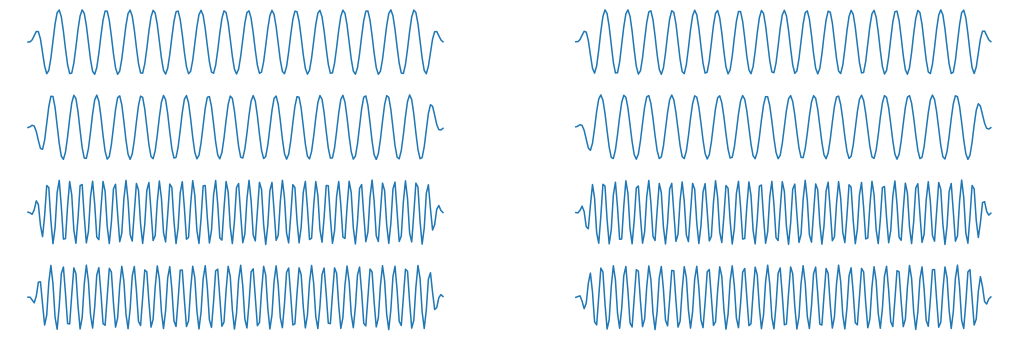

<Figure size 432x288 with 0 Axes>

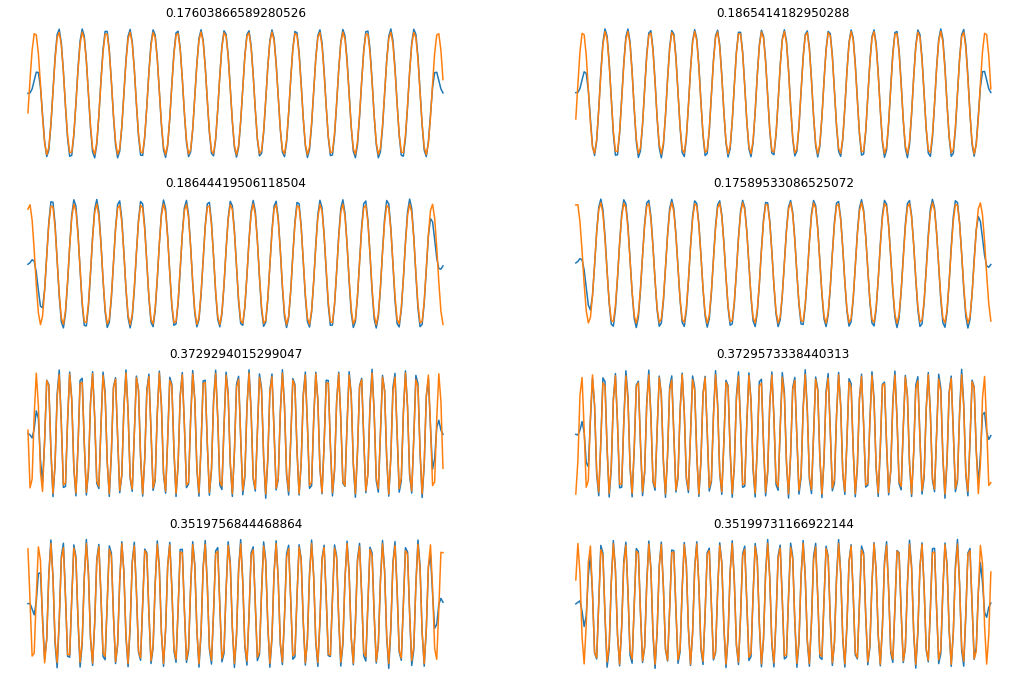

In [9]:
Phis,W,H = load_PhiWH(0,'tlnmf') # S=1, TLNMF
n_atoms = 8
shape_to_plot = (4, 2)

plt.figure()
f, ax = plt.subplots(*shape_to_plot)
f.set_size_inches(18, 12)
for axe, idx in zip(ax.ravel(), range(0,n_atoms)):
    axe.plot(Phis[idx])
    alpha,psi,amp,error = regress_atom(Phis[idx])
    fit = np.zeros(M)
    for m in range(M):
        fit[m] = amp*np.cos(alpha*m+psi)
    axe.plot(fit)    
    axe.axis('off')
    opta = (alpha/np.pi) % 2 # alpha%(2*np.pi)/np.pi
    opta = min(opta, 2-opta) # use neg freq to make sure opta in 0 nad 1
    axe.title.set_text(str(opta))
    print('%.2f\t%.2f' % (opta/2*fs[0],error))    
    #print('%d\t%g' % (idx+1,opta/2*fs[0]))

power ratio 0.9989525206923491
Phis (8, 200)
466.12	0.19
439.72	0.37
879.97	0.51
879.99	0.45
879.97	0.44
932.46	0.42
932.28	0.40
932.31	0.39


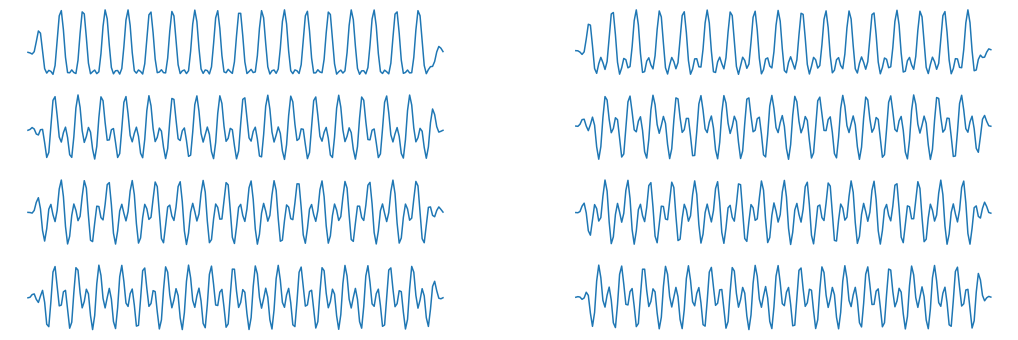

<Figure size 432x288 with 0 Axes>

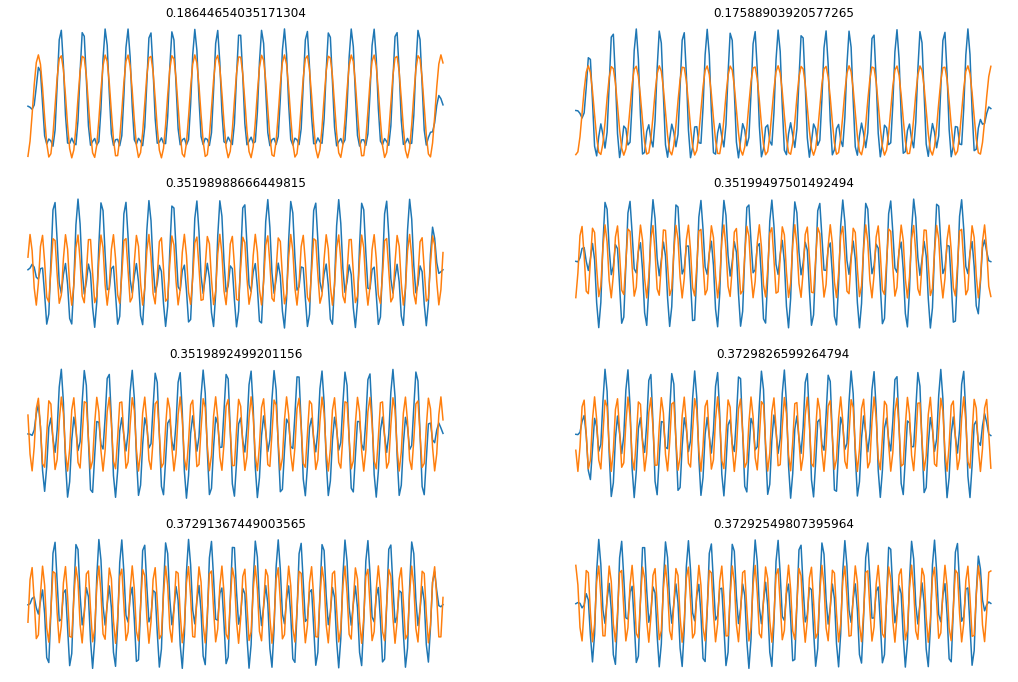

In [10]:
Phis,W,H = load_PhiWH(0,'jdnmf')

plt.figure()
f, ax = plt.subplots(*shape_to_plot)
f.set_size_inches(18, 12)
for axe, idx in zip(ax.ravel(), range(0,n_atoms)):
    axe.plot(Phis[idx])
    alpha,psi,amp,error = regress_atom(Phis[idx])
    fit = np.zeros(M)
    for m in range(M):
        fit[m] = amp*np.cos(alpha*m+psi)
    axe.plot(fit)    
    axe.axis('off')
    opta = (alpha/np.pi) % 2 # alpha%(2*np.pi)/np.pi
    opta = min(opta, 2-opta) # use neg freq to make sure opta in 0 nad 1
    axe.title.set_text(str(opta))
    print('%.2f\t%.2f' % (opta/2*fs[0],error))
    